In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
#sns.set(style = 'white', color_code=True)
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.shape,test.shape
# test.plot(y='LoanAmount',x='Loan_Amount_Term',kind='scatter')

((614, 13), (367, 12))

In [3]:
train['source'] = 'train'
test['source'] = 'test'

In [4]:
data = pd.concat([train,test],ignore_index=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981 entries, 0 to 366
Data columns (total 14 columns):
ApplicantIncome      981 non-null int64
CoapplicantIncome    981 non-null float64
Credit_History       902 non-null float64
Dependents           956 non-null object
Education            981 non-null object
Gender               957 non-null object
LoanAmount           954 non-null float64
Loan_Amount_Term     961 non-null float64
Loan_ID              981 non-null object
Loan_Status          614 non-null object
Married              978 non-null object
Property_Area        981 non-null object
Self_Employed        926 non-null object
source               981 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 115.0+ KB


In [5]:
data.apply(lambda x: sum(x.isnull()))

ApplicantIncome        0
CoapplicantIncome      0
Credit_History        79
Dependents            25
Education              0
Gender                24
LoanAmount            27
Loan_Amount_Term      20
Loan_ID                0
Loan_Status          367
Married                3
Property_Area          0
Self_Employed         55
source                 0
dtype: int64

In [6]:
data['Gender'].fillna('Male',inplace=True)
data['Married'].fillna('Yes',inplace=True)
data['Self_Employed'].fillna('No',inplace=True)
data['Dependents'].fillna('0',inplace=True)
data['Married'].fillna('Yes',inplace=True)
data['Credit_History'].fillna(1.0,inplace=True)
data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mean(),inplace=True)
impute_grps = data.pivot_table(values=["LoanAmount"], index=["Gender","Married","Self_Employed"], aggfunc=np.mean)

In [7]:
#Create a new function:
def num_missing(x):
  return sum(x.isnull())

#iterate only through rows with missing LoanAmount
for i,row in data.loc[data['LoanAmount'].isnull(),:].iterrows():
    ind = tuple([row['Gender'],row['Married'],row['Self_Employed']])
    data.loc[i,'LoanAmount'] = impute_grps.loc[ind].values[0]

#Now check the #missing values again to confirm:
print(data.apply(num_missing, axis=0))

ApplicantIncome        0
CoapplicantIncome      0
Credit_History         0
Dependents             0
Education              0
Gender                 0
LoanAmount             0
Loan_Amount_Term       0
Loan_ID                0
Loan_Status          367
Married                0
Property_Area          0
Self_Employed          0
source                 0
dtype: int64


In [8]:
data['Total_Income'] = data['ApplicantIncome'] + data['CoapplicantIncome']
data['Total_Income_log'] = np.log(data['Total_Income'])
#To remove outliers in LoanAmount 
data['LoanAmount_log'] = np.log(data['LoanAmount'])
data['Loan_Amount_Term_log'] = np.log(data['Loan_Amount_Term'])
data['EMI'] = data['LoanAmount_log']/data['Loan_Amount_Term_log']
data['Ratio'] = data['LoanAmount_log']/data['Total_Income_log']

data.drop('ApplicantIncome',axis=1,inplace=True)
data.drop('CoapplicantIncome',axis=1,inplace=True)
data.drop('Gender',axis=1,inplace=True)
data.drop('Self_Employed',axis=1,inplace=True)
data.drop('Total_Income',axis=1,inplace=True)
data.drop('LoanAmount',axis=1,inplace=True)
data.drop('Loan_Amount_Term',axis=1,inplace=True)

In [9]:
data.describe()

,Credit_History,Total_Income_log,LoanAmount_log,Loan_Amount_Term_log,EMI,Ratio
count,981.000000,981.000000,981.000000,981.000000,981.000000,981.000000
mean,0.849134,8.649904,4.849140,5.799637,0.840722,0.560604
std,0.358101,0.520593,0.463307,0.340169,0.120034,0.041816
min,0.000000,7.273786,2.197225,1.791759,0.373290,0.282637
25%,1.000000,8.334712,4.624973,5.886104,0.789043,0.544162
50%,1.000000,8.578100,4.852030,5.886104,0.828255,0.564651
75%,1.000000,8.896725,5.075174,5.886104,0.878422,0.583341
max,1.000000,11.302204,6.551080,6.173786,2.541567,0.694889


In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#var_to_encode = ['Dependents','Education','Gender','Married','Property_Area','Self_Employed']
var_to_encode = ['Married','Dependents','Education','Property_Area']
for col in var_to_encode:
    data[col] = le.fit_transform(data[col])

In [11]:
data = pd.get_dummies(data,columns=var_to_encode)

In [12]:
train = data.loc[data['source']=='train']
test = data.loc[data['source']=='test']

In [13]:
train.drop('source',axis=1,inplace=True)
test.drop(['source','Loan_Status'],axis=1,inplace=True)

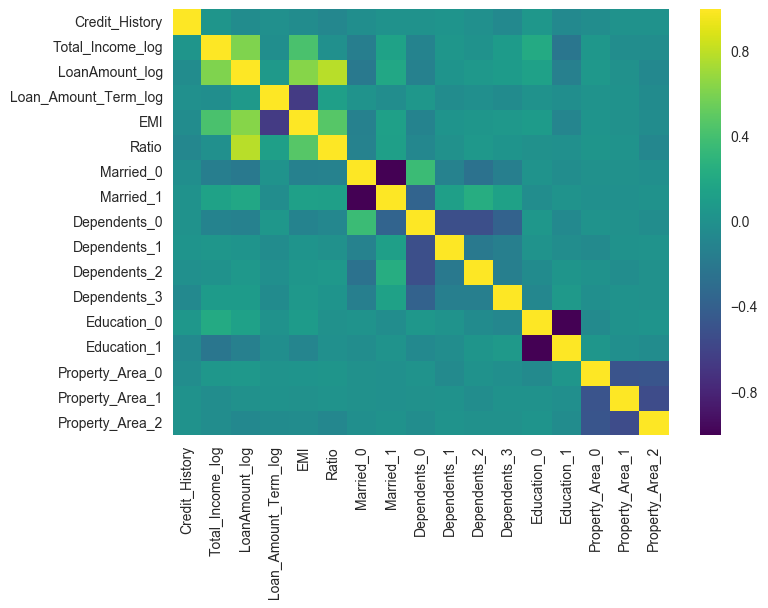

In [14]:
corr_temp = data.corr()
sns.heatmap(corr_temp,cmap='viridis')

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981 entries, 0 to 366
Data columns (total 20 columns):
Credit_History          981 non-null float64
Loan_ID                 981 non-null object
Loan_Status             614 non-null object
source                  981 non-null object
Total_Income_log        981 non-null float64
LoanAmount_log          981 non-null float64
Loan_Amount_Term_log    981 non-null float64
EMI                     981 non-null float64
Ratio                   981 non-null float64
Married_0               981 non-null float64
Married_1               981 non-null float64
Dependents_0            981 non-null float64
Dependents_1            981 non-null float64
Dependents_2            981 non-null float64
Dependents_3            981 non-null float64
Education_0             981 non-null float64
Education_1             981 non-null float64
Property_Area_0         981 non-null float64
Property_Area_1         981 non-null float64
Property_Area_2         981 non-null float6

In [16]:
data['Credit_Score'] = data['Married_1'] + data['Dependents_0'] + data['Education_1']

In [17]:
train.to_csv('train_modified27jan.csv',index=False)
test.to_csv('test_modified27jan.csv',index=False)